In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [88]:
df = pd.read_csv('../DATA/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [89]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [91]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

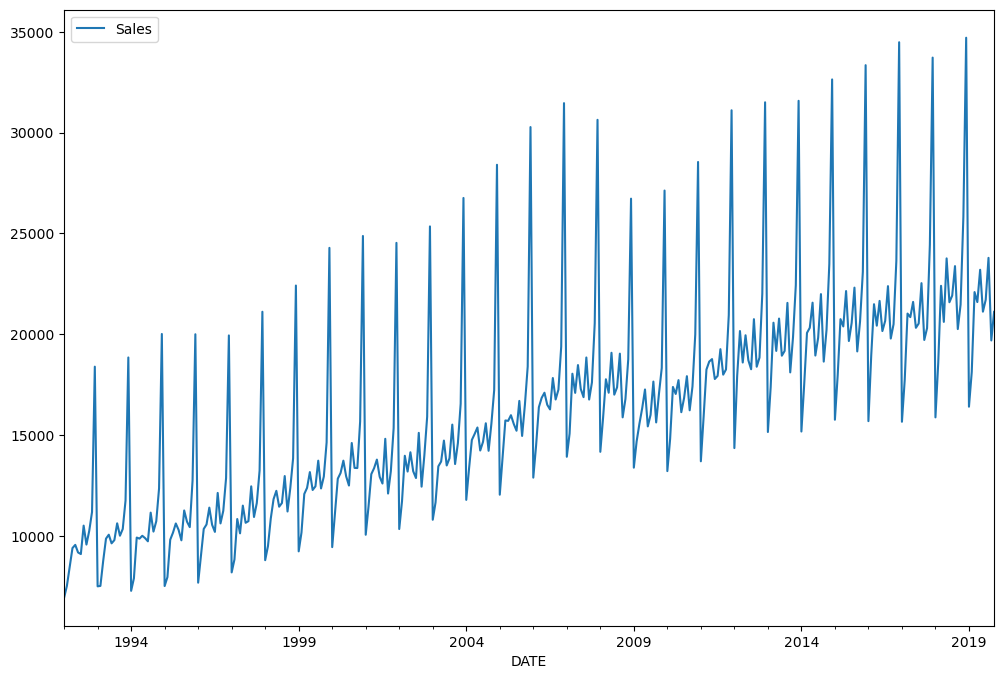

In [92]:
df.plot(figsize=(12,8))

In [93]:
len(df)-18

316

In [94]:
test_size = 18
test_index = len(df)- test_size

In [95]:
train = df.iloc[:test_index]

In [96]:
test = df.iloc[test_index:]

In [97]:
from sklearn.preprocessing import MinMaxScaler

In [98]:
scaler = MinMaxScaler()

In [99]:
scaler.fit(train)

MinMaxScaler()

In [100]:
scaled_train = scaler.transform(train)

In [101]:
scaled_test = scaler.transform(test)

In [102]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [103]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [104]:
X,y = generator[0]

In [105]:
from tensorflow.keras.models import Sequential

In [106]:
from tensorflow.keras.layers import Dense, LSTM

In [107]:
n_features = 1

In [108]:
model = Sequential()

model.add(LSTM(100,activation='relu', input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [109]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [110]:
from tensorflow.keras.callbacks import EarlyStopping

In [111]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [112]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [113]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20


C:\Users\Francisco\AppData\Local\Temp\ipykernel_14036\775669238.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])


304/304 [==============================] - 2s 3ms/step - loss: 0.0235 - val_loss: 0.0033
Epoch 2/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0173 - val_loss: 0.0246
Epoch 3/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 4/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 5/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 6/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 4.4162e-04
Epoch 7/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 8/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 9/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0049


In [114]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

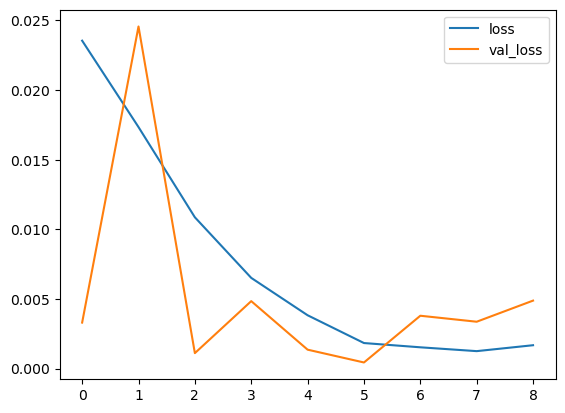

In [115]:
losses.plot()

In [116]:
test_prediction = []

fisrt_eval_batch = scaled_train[-length:]
current_batch = fisrt_eval_batch.reshape((1,length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 13ms/step


In [117]:
true_pred = scaler.inverse_transform(test_prediction)

In [118]:
test['Predictions'] = true_pred

C:\Users\Francisco\AppData\Local\Temp\ipykernel_14036\3456487850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_pred


In [119]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,23163.037682
2018-06-01,21589,21969.882491
2018-07-01,21919,22234.358620
2018-08-01,23381,24055.020340
2018-09-01,20260,21556.141706
2018-10-01,21473,22130.294633
2018-11-01,25831,25993.710775
2018-12-01,34706,34506.813415
2019-01-01,16410,18009.039958


<AxesSubplot:xlabel='DATE'>

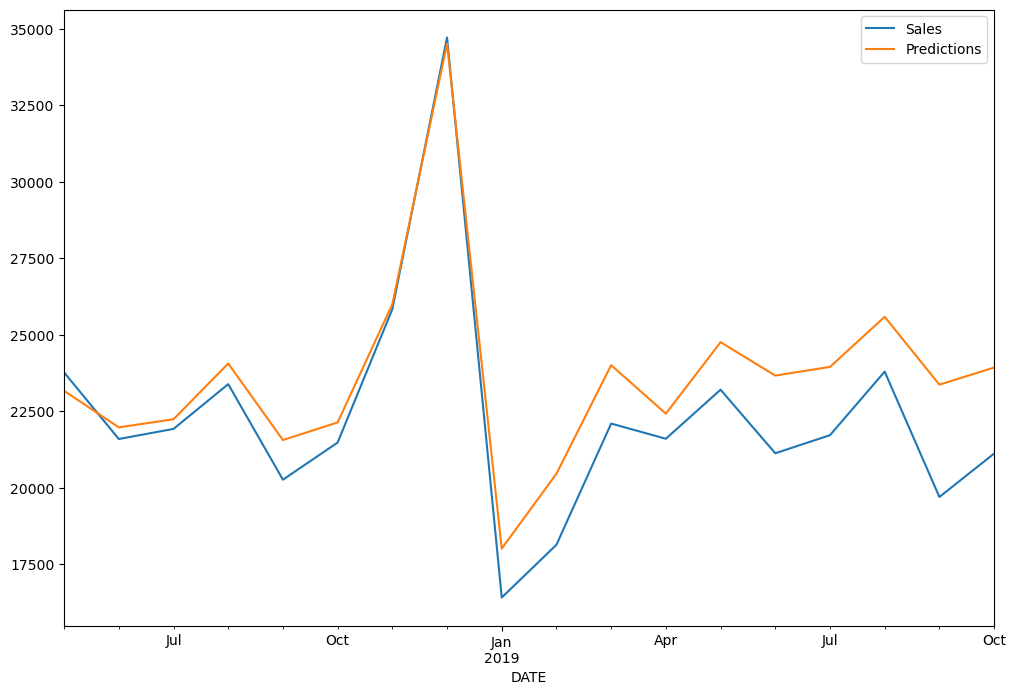

In [120]:
test.plot(figsize=(12,8))

In [122]:
full_Scaler = MinMaxScaler()

scaled_full = full_Scaler.fit_transform(df)

In [123]:
length = 12
generator = TimeseriesGenerator(scaled_full, scaled_full, length=length, batch_size=1)

In [124]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs= 8)

Epoch 1/8


C:\Users\Francisco\AppData\Local\Temp\ipykernel_14036\2555453298.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs= 8)


322/322 [==============================] - 1s 2ms/step - loss: 0.0251
Epoch 2/8
322/322 [==============================] - 1s 2ms/step - loss: 0.0170
Epoch 3/8
322/322 [==============================] - 1s 2ms/step - loss: 0.0123
Epoch 4/8
322/322 [==============================] - 1s 2ms/step - loss: 0.0052
Epoch 5/8
322/322 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 6/8
322/322 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 7/8
322/322 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 1s 2ms/step - loss: 0.0014


In [136]:
forecast = []
periods = 12

fisrt_eval_batch = scaled_train[-length:]
current_batch = fisrt_eval_batch.reshape((1,length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 14ms/step


In [137]:
forecast = full_Scaler.inverse_transform(forecast)

In [138]:
forecast

array([[21941.30229855],
       [20770.21103787],
       [21026.25114489],
       [22911.00987816],
       [20306.85867524],
       [20989.44002628],
       [25037.13375854],
       [34786.16981983],
       [16606.97713327],
       [18947.09822536],
       [22634.4738183 ],
       [20976.93407726]])

In [139]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods, freq='MS')

In [140]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

<AxesSubplot:>

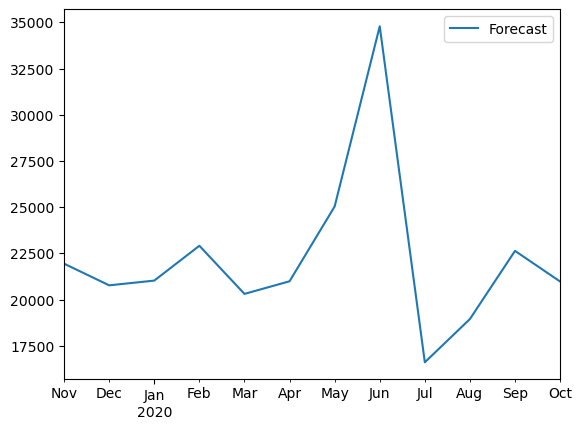

In [142]:
forecast_df.plot()

(576.0, 611.0)

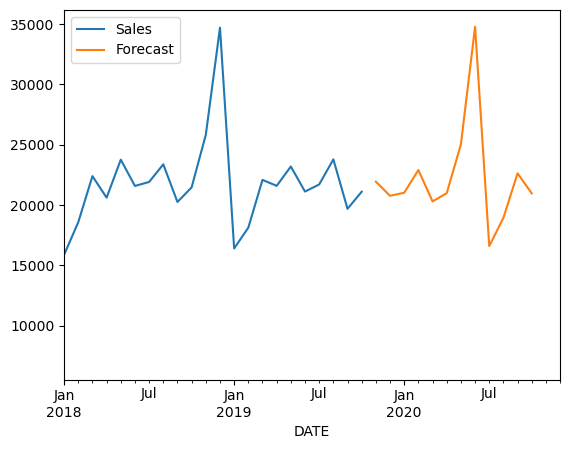

In [144]:
ax = df.plot()

forecast_df.plot(ax=ax)

plt.xlim('2018-01-01', '2020-12-01')